#NLP Tutorial for Text Classification in Python

Unstructured data in the form of text: chats, emails, social media, survey responses is present everywhere today. Text can be a rich source of information, but due to its unstructured nature it can be hard to extract insights from it.

Text classification is one of the important task in supervised machine learning (ML). It is a process of assigning tags/categories to documents helping us to automatically & quickly structure and analyze text in a cost-effective manner. It is one of the fundamental tasks in Natural Language Processing with broad applications such as sentiment-analysis, spam-detection, topic-labeling, intent-detection etc.


In this article, I would like to take you through the step by step process of how we can do text classification using Python. I have uploaded the complete code on GitHub: https://github.com/vijayaiitk/NLP-text-classification-model
Let’s divide the classification problem into the below steps:


Original Source - https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

* Setup: Importing Libraries
* Loading the data set & Exploratory Data Analysis
* Text pre-processing
* Extracting vectors from text (Vectorization)
* Running ML algorithms
* Conclusion

## Step 1: Importing Libraries
The first step is to import the following list of libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Step 2: Loading the data set & EDA
The data set that we will be using for this article is the famous “Natural Language Processing with Disaster Tweets” data set where we’ll be predicting whether a given tweet is about a real disaster (target=1) or not (target=0)

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which ones aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.
Loading the data set in Kaggle Notebook:

https://www.kaggle.com/c/nlp-getting-started/overview

In [2]:
df_train= pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

We have 7,613 tweets in training (labelled) dataset and 3,263 in the test(unlabelled) dataset. Here’s a snapshot of the training/labelled dataset which we’ll use for building our model


In [3]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


##Exploratory Data Analysis (EDA)
Class distribution: There are more tweets with class 0 ( no disaster) than class 1 ( disaster tweets). We can say that the dataset is relatively balanced with 4342 non-disaster tweets (57%) and 3271 disaster tweets (43%). Since the data is balanced, we won’t be applying data-balancing techniques like SMOTE while building the model

0    4342
1    3271
Name: target, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


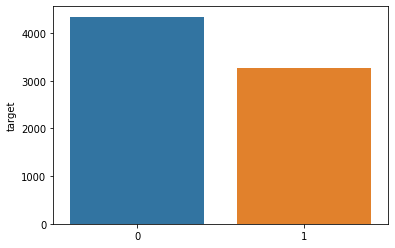

In [4]:
x=df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

2. Missing values: We have ~2.5k missing values in location field and 61 missing values in keyword column

In [5]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

3. Number of words in a tweet: Disaster tweets are more wordy than the non-disaster tweets

In [6]:
# WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['word_count'].mean()) #Non-Disaster tweets

15.167532864567411
14.704744357438969


The average number of words in a disaster tweet is 15.17 as compared to an average of 14.7 words in a non-disaster tweet

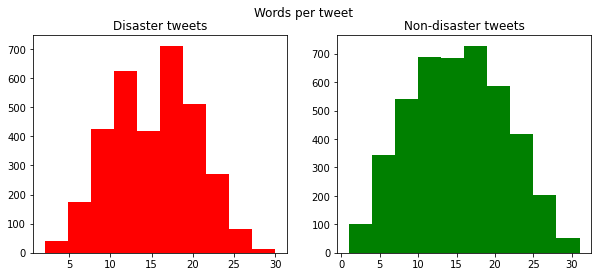

In [7]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

4. Number of characters in a tweet: Disaster tweets are longer than the non-disaster tweets

In [8]:
# CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==1]['char_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['char_count'].mean()) #Non-Disaster tweets

108.11342097217977
95.70681713496084


The average characters in a disaster tweet is 108.1 as compared to an average of 95.7 characters in a non-disaster tweet
#Step 3: Text Pre-Processing
Before we move to model building, we need to preprocess our dataset by removing punctuations & special characters, cleaning texts, removing stop words, and applying lemmatization
Simple text cleaning processes: Some of the common text cleaning process involves:

* Removing punctuations, special characters, URLs & hashtags
* Removing leading, trailing & extra white spaces/tabs
* Typos, slangs are corrected, abbreviations are written in their long forms


Stop-word removal: We can remove a list of generic stop words from the English vocabulary using nltk. A few such words are ‘i’,’you’,’a’,’the’,’he’,’which’ etc.
Stemming: Refers to the process of slicing the end or the beginning of words with the intention of removing affixes(prefix/suffix)
Lemmatization: It is the process of reducing the word to its base form

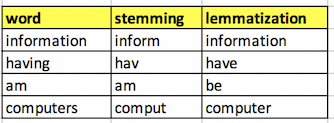

Here’s the code for text pre-processing:

In [9]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
    
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

Final pre-processing

In [10]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
    
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))

df_train.head()

,id,keyword,location,text,target,word_count,char_count,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,get sent photo ruby alaska smoke wildfires pou...


#Step 4: Extracting vectors from text (Vectorization)
It’s difficult to work with text data while building Machine learning models since these models need well-defined numerical data. The process to convert text data into numerical data/vector, is called vectorization or in the NLP world, word embedding. Bag-of-Words(BoW) and Word Embedding (with Word2Vec) are two well-known methods for converting text data to numerical data.
There are a few versions of Bag of Words, corresponding to different words scoring methods. We use the Sklearn library to calculate the BoW numerical values using these approaches:

Count vectors: It builds a vocabulary from a corpus of documents and counts how many times the words appear in each document

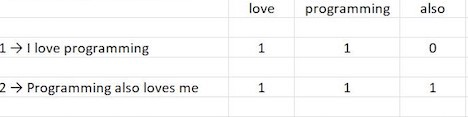

##2. Term Frequency-Inverse Document Frequencies (tf-Idf):
Count vectors might not be the best representation for converting text data to numerical data. So, instead of simple counting, we can also use an advanced variant of the Bag-of-Words that uses the term frequency–inverse document frequency (or Tf-Idf). Basically, the value of a word increases proportionally to count in the document, but it is inversely proportional to the frequency of the word in the corpus

Word2Vec: One of the major drawbacks of using Bag-of-words techniques is that it can’t capture the meaning or relation of the words from vectors. Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network which is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

We can use any of these approaches to convert our text data to numerical form which will be used to build the classification model. With this in mind, I am going to first partition the dataset into training set (80%) and test set (20%) using the below-mentioned code

In [11]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["target"],test_size=0.2,shuffle=True)


#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

Here’s the code for vectorization using Bag-of-Words (with Tf-Idf ) and Word2Vec

In [27]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])



# Step 5. Running ML algorithms
It’s time to train a machine learning model on the vectorized dataset and test it. Now that we have converted the text data to numerical data, we can run ML models on X_train_vector_tfidf & y_train. We’ll test this model on X_test_vectors_tfidf to get y_predict and further evaluate the performance of the model
Logistic Regression: We will start with the most simplest one Logistic Regression. You can easily build a LogisticRegression in scikit using below lines of code

In [13]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       855
           1       0.77      0.76      0.76       668

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523

Confusion Matrix: [[705 150]
 [163 505]]
AUC: 0.8651293903421228


#2. Naive Bayes: 
It’s a probabilistic classifier that makes use of Bayes’ Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related

In [15]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       855
           1       0.85      0.67      0.75       668

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523

Confusion Matrix: [[773  82]
 [220 448]]
AUC: 0.8622947088279581


You can now select the best model (lr_tfidf in our case) to estimate ‘target’ values for the unlabelled dataset (df_test). Here’s the code for that

In [16]:
#Pre-processing the new dataset
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 

#converting words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)

#use the best model to predict 'target' value for the new dataset 
y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
final=df_test[['clean_text','target']].reset_index(drop=True)

print(final.head())

                                          clean_text  target
0                          happen terrible car crash       1
1  heard earthquake different city stay safe ever...       1
2  forest fire spot pond geese flee across street...       1
3                  apocalypse light spokane wildfire       1
4                 typhoon soudelor kill china taiwan       1


#Conclusion
In this article, I demonstrated the basics of building a text classification model comparing Bag-of-Words (with Tf-Idf) and Word Embedding with Word2Vec. You can further enhance the performance of your model using this code by
using other classification algorithms like Support Vector Machines (SVM), XgBoost, Ensemble models, Neural networks etc.
using Gridsearch to tune the hyperparameters of your model
using advanced word-embedding methods like GloVe and BERT